# Introduction
- In this kernel, we will be implementing the **Windy Gridworld** environment. A complete and extensive description of the same can be found in the book on **Reinforcement Learning** by **Richard S. Sutton and Andrew G. Barto**. Check out **Example 6.5** (Page - 130).
- We will be deploying SARSA, Q-Learning and Expected SARSA to try and find the optimal agent's policy and the optimal value functions, in order to maximize the rewards.
- This implementation is based on **RL-Glue**, a standard, language-independent software package for reinforcement-learning experiments. The standardization provided by RL-Glue facilitates code sharing and collaboration. Feel free to read more about it [here](https://jmlr.csail.mit.edu/papers/v10/tanner09a.html), and I borrowed the implementation from [here](https://github.com/andnp/coursera-rl-glue).

# Importing Packages & Boilerplate Stuff

1. jdc: Jupyter magic that allows defining classes over multiple jupyter notebook cells.
2. numpy: the fundamental package for scientific computing with Python.
3. matplotlib: the library for plotting graphs in Python.
4. RL-Glue: the library for reinforcement learning experiments.
5. BaseEnvironment, BaseAgent: the base classes from which we will inherit when creating the environment and agent classes in order for them to support the RL-Glue framework.
6. itertools.product: the function that can be used easily to compute permutations.
7. tqdm.tqdm: Provides progress bars for visualizing the status of loops.

## Next Things to Try
- Decrease epsilon over the episodes, since larger values of epsilon are in general leading to faster convergence, but at the same time, it's also leading to policies which won't terminate.

In [1]:
import jdc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from rl_glue import RLGlue
from Agent import BaseAgent 
from Environment import BaseEnvironment
from itertools import product
from tqdm import tqdm

In [2]:
### DEBUG CODE
# Setting the seed for reproducible results
# np.random.seed(0)

# 1. Environment
- The below code cell provides the backbone of the `WindyGridEnvironment` class.

In [3]:
class WindyGridEnvironment(BaseEnvironment):
    def env_init(self, env_info={}):
        raise NotImplementedError

    def env_start(self):
        raise NotImplementedError

    def env_step(self, action):
        raise NotImplementedError

    def env_cleanup(self):
        raise NotImplementedError
        
    # Helper method
    def helper_method(self):
        raise NotImplementedError

## 1.1. env_init()
- All the characteristics of the environment that are constant throughout the episodes are defined in this method (*i.e., need to be defined only once, in the starting of the experiment*).
- Remember `env_init` will only be called in the beginning of the experiment, not in the beginning of each episode. So, if some attributes need to be defined in the beginning of each episode, set them in `env_start`.

In [4]:
%%add_to WindyGridEnvironment

def env_init(self, env_info={}):
    """
    Setup for the environment called when the experiment first starts.
    Args:
        env_info: Contains the information for the environment
    """
    
    ## NOTE: The indexing of the gridworld begins from the top-left corner
    
    # Define the windy grid-world; this indicates the wind in each of the columns
    self.grid_world = np.zeros((7, 10), dtype = 'int8')
    self.grid_world[ : , 3:6] = 1
    self.grid_world[ : , 6:8] = 2
    self.grid_world[ : , 8]   = 1
    
    # Define the starting and goal locations of agent in each episode
    self.start_loc = [3, 0]
    self.goal_loc  = [3, 7]
    
    # Define the reward for the grid-world
    self.reward = -1
    
    # Define the current location of the agent; changes with each step
    self.cur_loc = None
    
    # Define the reward-state-term; changes with each step
    self.reward_state_term = None
    
    # Define the number of time steps elapsed in a single episode
    self.number_of_steps = None
    
    # Defining a random generator
    self.rand_generator = np.random.RandomState(agent_info.get("seed", 0))

## 1.2. env_start()
- All the characteristics of the environment that are varying across the episodes are defined in this method.

In [5]:
%%add_to WindyGridEnvironment

def env_start(self):
    """
    The first method called when the episode starts, called before the
    agent starts.
    Returns:
        The first state from the environment.
    """
    
    # Define the initial state of the agent
    self.cur_loc = self.start_loc
    
    # Trying out random initialization of the state
    # self.cur_loc = [self.rand_generator.choice(np.arange(7)), 
    #     self.rand_generator.choice(np.arange(10))]
    
    # Defining the initial reward_state_term
    self.reward_state_term = (0, self.cur_loc, False)
    
    # Define the initial number of time steps
    self.number_of_steps = 1
    
    return self.reward_state_term[1]

## 1.3. env_step()
- There are 4 possible values for the action. Let's define them here:
    - 0: UP
    - 1: RIGHT
    - 2: DOWN
    - 3: LEFT

In [6]:
%%add_to WindyGridEnvironment

def env_step(self, action):
    """
    A step taken by the environment.
    Args:
        action: The action taken by the agent
    Returns:
        (reward, state, boolean): a tuple of the reward, state,
            and boolean indicating if it's terminal.
    """
    
    # Determine the wind strength in the current column
    # This wind strength is used to determine the actual state due to any action ...
    # ... taken from the present state.
    wind = self.grid_world[self.cur_loc[0], self.cur_loc[1]]
    
    # The first update is the regular update
    # The second update is due to the wind
    # Remember that the wind only flows in the upward direction
    
    # UP
    if action == 0:
        self.cur_loc[0] = max(0, self.cur_loc[0] - 1)
        self.cur_loc[0] = max(0, self.cur_loc[0] - wind)
    
    # RIGHT
    elif action == 1:
        self.cur_loc[1] = min(9, self.cur_loc[1] + 1)
        self.cur_loc[0] = max(0, self.cur_loc[0] - wind)
    
    # DOWN
    elif action == 2:
        self.cur_loc[0] = min(6, self.cur_loc[0] + 1)
        self.cur_loc[0] = max(0, self.cur_loc[0] - wind)
    
    # LEFT
    elif action == 3:
        self.cur_loc[1] = max(0, self.cur_loc[1] - 1)
        self.cur_loc[0] = max(0, self.cur_loc[0] - wind)
        
    if self.cur_loc == self.goal_loc:
        self.reward_state_term = (0, self.cur_loc, True)
    else:
        self.reward_state_term = (self.reward, self.cur_loc, False)
    
    ### DEBUGGING CODE
    # if self.number_of_steps % 10000 == 0:
    #     print("Number of Time Steps Elapsed:", self.number_of_steps)
    #     print("Current State of the Agent:", self.cur_loc)
    
    self.number_of_steps += 1
    return self.reward_state_term

## 1.4. env_cleanup()
- This method sets the environment attributes to their default values once the experiment terminates.

In [7]:
%%add_to WindyGridEnvironment

def env_cleanup(self):
    """Cleanup done after the environment ends"""
    
    # Default values for the environment & the agent
    self.grid_world = None
    self.start_loc  = None
    self.goal_loc   = None
    self.reward     = None
    self.cur_loc    = None
    self.reward_state_term = None
    self.number_of_steps   = None 

In [8]:
# ### DEBUGGING CODE
# env = WindyGridEnvironment()
# env.env_init()
# print(env.grid_world)

# env.env_start()
# print(env.reward_state_term)

# # UP FROM [3, 0]
# rst = env.env_step(0) 
# rst = env.env_step(0) 
# rst = env.env_step(0) 
# rst = env.env_step(0) 
# print(rst)

# # RIGHT FROM [0, 0]
# rst = env.env_step(1) 
# rst = env.env_step(1) 
# rst = env.env_step(1) 
# rst = env.env_step(1) 
# rst = env.env_step(1) 
# rst = env.env_step(1) 
# rst = env.env_step(1) 
# rst = env.env_step(1) 
# rst = env.env_step(1) 
# print(rst)

# # DOWN FROM [0, 9]
# rst = env.env_step(2) 
# rst = env.env_step(2) 
# rst = env.env_step(2) 
# rst = env.env_step(2) 
# print(rst)

# # LEFT FROM [4, 9]
# rst = env.env_step(3) 
# rst = env.env_step(3) 
# print(rst)

# 2. Learning Agents
- The below code cells provides the backbone of the Learning Agents classes.

### agent_init()
- All the characteristics of the agent that are constant throughout the episodes are defined in this method.
- The characteristics of the agent that can be modified are the **discount factor, step-size and the epsilon for exploration-exploitation trade-off**. They can be set using the `discount`, `step_size` and `epsilon` keys of the `agent_info` dictionary.

### agent_start()
- This method is called at the starting of each episode, and it receives the starting state of each episode.

### agent_step()
- This method is called throughout the episode until the agent reaches the terminal state.

### agent_end()
- This method is called when the agent reaches the terminal state, i.e., the end of an episode.

### agent_message()
- This is just a method to get some information from the agent's attributes, for instance, the Q-Values.

### argmax()
- This is just a helper method. `np.argmax` doesn't break the ties randomly, hence, we have written a custom implementation of `argmax` which does exactly that.

### state_to_index() and index_to_state()
- `state_to_index` converts the state `[int, int]` to a single index `int`, and `index_to_state` does the exact opposite.

In [9]:
class QLearningAgent(BaseAgent):
    
    def agent_init(self, agent_info={}):
        """
        Setup for the agent called when the experiment first starts.
        Args:
            agent_info: Contains the information for the agent
        """
    
        # Defining the #actions and #states 
        self.num_actions = 4
        self.num_states = 70
        
        # Discount factor (gamma) to use in the updates.
        self.discount = agent_info.get("discount", 1)

        # The learning rate or step size parameter (alpha) to use in updates.
        self.step_size = agent_info.get("step_size", 0.1)

        # To control the exploration-exploitation trade-off
        self.epsilon = agent_info.get("epsilon", 0.1)
        
        # Define the number of time steps elapsed in a single episode
        self.number_of_steps = None
        
        # Defining a random generator
        self.rand_generator = np.random.RandomState(agent_info.get("seed", 0))
        
        # Defining the initial action values
        # self.q = np.zeros((self.num_states, self.num_actions))
        self.q = self.rand_generator.uniform(0, 0.1, (self.num_states, self.num_actions))
    
    
    def agent_start(self, state):
        """
        The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state observation from the environment's env_start method.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Convert the state to an index
        index = self.state_to_index(state)
        
        # Choose action using epsilon greedy.
        current_q = self.q[index][:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
            
        self.prev_state = state
        self.prev_action = action
        self.number_of_steps = 1
        return action

    
    def agent_step(self, reward, state):
        """
        A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state observation from the environment's step 
                based on where the agent ended up after the last step.
        Returns:
            action (int): the action the agent is taking.
        """

        # Convert the state to an index
        index = self.state_to_index(state)
        prev_index = self.state_to_index(self.prev_state)

        ### DEBUGGING CODE
        # print(f"Previous State: {self.prev_state}")
        # print(f"Current State: {state}")
        # print(f"Current Value: {self.q[prev_index, self.prev_action]}")
        
        # Choose action using epsilon greedy.
        current_q = self.q[index][:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)

        # Perform an update
        max_val = -1e8
        for act in range(self.num_actions):
            val = self.q[prev_index, self.prev_action] + self.step_size * (
                reward + self.discount * self.q[index, act] - self.q[prev_index, self.prev_action]
            )
            max_val = max(max_val, val)
        self.q[prev_index, self.prev_action] = max_val

        ### DEBUGGING CODE
        # print(f"Updated Value: {self.q[prev_index, self.prev_action]}")
        # print()

        self.prev_state = state
        self.prev_action = action
        self.number_of_steps += 1
        return action
    
    
    def agent_end(self, reward):
        """
        Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        
        # Convert the state to an index
        prev_index = self.state_to_index(self.prev_state)  
        
        # Perform an update
        max_val = -1e8
        for action in range(self.num_actions):
            val = self.q[prev_index, self.prev_action] + self.step_size * (
                reward + self.discount * 0 - self.q[prev_index, self.prev_action]
            )
            max_val = max(max_val, val)
        self.q[prev_index, self.prev_action] = max_val
        self.number_of_steps += 1
        
        
    def agent_message(self, message):
        """
        A method used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent
        Returns:
            The response (or answer) to the message
        """
        if message == "get_values":
            return self.q
        elif message == "get_steps":
            return self.number_of_steps
        else:
            raise Exception("TDAgent.agent_message(): Message not understood!")

            
    # Helper method
    def argmax(self, q_values):        
        """
        argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)
        
        
    # Helper method
    def state_to_index(self, state):
        """
        Converts the state into an index
        Args:
            state ([int, int]]): the state to transform
        Returns:
            index (int): the index of the state
        """
        
        return int(state[0] * 10 + state[1])
    
    
    # Helper method
    def index_to_state(self, index):
        """
        Converts the index into the state
        Args:
            index (int): the index of the state
        Returns:
            state ([int, int]]): the state to transform
        """
        
        return [int(index/10), (index%10)]       

In [10]:
class SarsaLearningAgent(BaseAgent):
    
    def agent_init(self, agent_info={}):
        """
        Setup for the agent called when the experiment first starts.
        Args:
            agent_info: Contains the information for the agent
        """
    
        # Defining the #actions and #states 
        self.num_actions = 4
        self.num_states = 70
        
        # Discount factor (gamma) to use in the updates.
        self.discount = agent_info.get("discount", 1)

        # The learning rate or step size parameter (alpha) to use in updates.
        self.step_size = agent_info.get("step_size", 0.1)

        # To control the exploration-exploitation trade-off
        self.epsilon = agent_info.get("epsilon", 0.1)
        
        # Define the number of time steps elapsed in a single episode
        self.number_of_steps = None
        
        # Defining a random generator
        self.rand_generator = np.random.RandomState(agent_info.get("seed", 0))
        
        # Defining the initial action values
        # self.q = np.zeros((self.num_states, self.num_actions))
        self.q = self.rand_generator.uniform(0, 0.1, (self.num_states, self.num_actions))
    
    
    def agent_start(self, state):
        """
        The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state observation from the environment's env_start method.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Convert the state to an index
        index = self.state_to_index(state)
        
        # Choose action using epsilon greedy.
        current_q = self.q[index][:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
            
        self.prev_state = state
        self.prev_action = action
        self.number_of_steps = 1
        return action

    
    def agent_step(self, reward, state):
        """
        A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state observation from the environment's step 
                based on where the agent ended up after the last step.
        Returns:
            action (int): the action the agent is taking.
        """

        # Convert the state to an index
        index = self.state_to_index(state)
        prev_index = self.state_to_index(self.prev_state)

        ### DEBUGGING CODE
        # print(f"Previous State: {self.prev_state}")
        # print(f"Current State: {state}")
        # print(f"Current Value: {self.q[prev_index, self.prev_action]}")
        
        # Choose action using epsilon greedy.
        current_q = self.q[index][:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)

        # Perform an update
        self.q[prev_index, self.prev_action] += self.step_size * (
            reward + self.discount * self.q[index, action] - self.q[prev_index, self.prev_action]
        )

        ### DEBUGGING CODE
        # print(f"Updated Value: {self.q[prev_index, self.prev_action]}")
        # print()

        self.prev_state = state
        self.prev_action = action
        self.number_of_steps += 1
        return action

    
    def agent_end(self, reward):
        """
        Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        
        # Convert the state to an index
        prev_index = self.state_to_index(self.prev_state)  
        
        # Perform an update
        self.q[prev_index, self.prev_action] += self.step_size * (
            reward + self.discount * 0 - self.q[prev_index, self.prev_action]
        )
        self.number_of_steps += 1
        
        
    def agent_message(self, message):
        """
        A method used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent
        Returns:
            The response (or answer) to the message
        """
        if message == "get_values":
            return self.q
        elif message == "get_steps":
            return self.number_of_steps
        else:
            raise Exception("TDAgent.agent_message(): Message not understood!")

            
    # Helper method
    def argmax(self, q_values):        
        """
        argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)
        
        
    # Helper method
    def state_to_index(self, state):
        """
        Converts the state into an index
        Args:
            state ([int, int]]): the state to transform
        Returns:
            index (int): the index of the state
        """
        
        return int(state[0] * 10 + state[1])
    
    
    # Helper method
    def index_to_state(self, index):
        """
        Converts the index into the state
        Args:
            index (int): the index of the state
        Returns:
            state ([int, int]]): the state to transform
        """
        
        return [int(index/10), (index%10)]       

In [11]:
# ### DEBUGGING CODE
# agent = SarsaLearningAgent()
# agent.agent_init()

# act = agent.agent_start([3, 0])
# print(act)

# act = agent.agent_step(-1, [3, 1])
# print(act)

# act = agent.agent_step(-1, [4, 8])
# print(act)

# act = agent.agent_step(-1, [5, 6])
# print(act)

# 3. Plotting Functions
- In this section, I have defined 2 plotting functions:
    - `plt_opt_policy`: It plots the optimal policy corresponding to the current Q-Values.
    - `plt_opt_val`: It plots the optimal state values corresponding to the current Q-Values.

In [12]:
def state_to_index(state):
    return int(state[0] * 10 + state[1])

def index_to_state(index):
    return [int(index/10), (index%10)]   

# 4. Running Experiments

In [13]:
def run_experiment(agent, env_info, agent_info, num_episode = 1000, plot = True):
    # An array to store the number of time-steps taken by each episode
    steps_arr = []
    
    env = WindyGridEnvironment
    
    # Defining the agent
    if agent == 'q_learning':
        agent = QLearningAgent
    elif agent == 'sarsa':
        agent = SarsaLearningAgent
    
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    
    for episode in range(1, num_episode + 1):
        rl_glue.rl_episode(0)
        num_steps = rl_glue.agent.agent_message("get_steps")
        steps_arr.append(num_steps)

        if episode % 50 == 0:
            print(f"Episode = {episode} | #Steps Taken = {num_steps}")
            q_vals = rl_glue.agent.agent_message("get_values")
            q_random = np.reshape(q_vals, (7, 10, 4))
            actions = np.argmax(q_random, axis = -1)
            values = np.max(q_random, axis = -1)
            print("Actions", actions)
            # print("Values", values)
            print()
        
    return q_vals, steps_arr

- 0: UP
- 1: RIGHT
- 2: DOWN
- 3: LEFT

In [14]:
# Defining the characteristics for the environment
env_info = {}

# Defining the characteristics for the agent
agent_info = {
    "discount": 1,       # UNDISCOUNTED
    "step_size": 0.5,
    "epsilon": 0.4,
    "seed": 0
}

num_episode = 500

In [15]:
agent = "sarsa"
q_optimal_sarsa, num_steps_sarsa = run_experiment(agent, env_info, agent_info, 
    num_episode = num_episode, plot = True)

Episode = 50 | #Steps Taken = 156378
Actions [[1 2 2 1 2 3 1 3 3 2]
 [1 0 3 0 3 3 0 1 1 3]
 [1 3 0 3 3 3 2 1 1 3]
 [1 0 3 3 0 0 3 1 1 3]
 [1 3 0 3 0 3 0 0 1 3]
 [1 0 3 3 3 1 1 0 0 3]
 [0 0 3 2 2 3 1 2 1 0]]

Episode = 100 | #Steps Taken = 665537
Actions [[1 2 2 2 1 1 3 1 3 2]
 [1 1 3 0 3 3 0 1 1 3]
 [1 1 0 0 3 3 2 1 1 3]
 [1 0 2 3 3 0 3 1 1 3]
 [1 3 3 3 0 3 0 0 1 3]
 [1 3 3 3 3 1 1 0 0 3]
 [0 0 3 2 2 3 1 2 1 0]]

Episode = 150 | #Steps Taken = 751489
Actions [[1 2 2 1 1 1 3 1 3 2]
 [1 0 3 0 3 3 0 1 1 3]
 [1 3 0 3 3 3 2 1 1 3]
 [1 0 3 3 0 0 3 1 1 3]
 [1 3 0 0 0 3 0 0 1 3]
 [1 0 3 3 3 1 1 0 0 3]
 [0 0 3 2 2 3 1 2 1 0]]

Episode = 200 | #Steps Taken = 268687
Actions [[1 2 2 1 1 1 0 1 3 2]
 [1 1 3 0 0 3 0 1 1 3]
 [1 3 0 3 3 3 2 1 1 3]
 [1 0 3 3 3 0 3 1 1 3]
 [1 1 0 3 0 3 0 0 1 3]
 [1 0 3 3 3 1 1 0 0 3]
 [0 0 3 2 2 3 1 2 1 0]]

Episode = 250 | #Steps Taken = 722429
Actions [[1 2 2 1 1 0 1 1 3 2]
 [1 0 1 0 3 3 0 1 1 3]
 [1 3 0 3 3 3 2 1 1 3]
 [1 0 3 3 0 0 3 1 1 3]
 [1 3 0 3 0 3 0 0 1 3]
 [1 

In [16]:
agent = "q_learning"
q_optimal_qlearn, num_steps_qlearn = run_experiment(agent, env_info, agent_info, 
    num_episode = num_episode, plot = True)

Episode = 50 | #Steps Taken = 40519
Actions [[1 2 2 1 1 1 1 1 3 2]
 [1 1 3 0 3 3 0 1 1 3]
 [1 0 3 0 3 3 2 1 1 3]
 [1 0 3 3 3 0 3 1 1 3]
 [1 3 0 3 0 3 0 0 1 3]
 [1 3 3 3 3 1 1 0 0 3]
 [0 0 3 2 2 3 1 2 1 0]]

Episode = 100 | #Steps Taken = 1476285
Actions [[1 2 2 1 1 1 1 1 2 2]
 [1 1 0 0 0 3 0 1 1 3]
 [1 0 3 3 3 3 2 1 1 3]
 [1 3 3 3 3 0 3 1 1 3]
 [1 0 3 3 0 3 0 0 1 3]
 [1 0 3 3 3 1 1 0 0 3]
 [0 0 3 2 2 3 1 2 1 0]]

Episode = 150 | #Steps Taken = 116641
Actions [[1 2 2 1 1 1 1 1 3 2]
 [1 1 3 0 0 3 0 1 1 3]
 [1 1 3 0 3 3 0 1 1 3]
 [1 0 3 3 3 0 3 1 1 3]
 [1 3 0 3 0 3 0 0 1 3]
 [1 3 3 3 3 1 1 0 0 3]
 [0 0 3 2 2 3 1 2 1 0]]

Episode = 200 | #Steps Taken = 248767
Actions [[1 2 2 1 1 3 1 1 3 2]
 [1 1 0 0 3 3 0 1 1 3]
 [1 0 3 3 3 3 0 1 1 3]
 [1 3 3 3 3 0 3 1 1 3]
 [1 3 2 3 0 3 0 0 1 3]
 [1 0 3 3 3 1 1 0 0 3]
 [0 0 3 2 2 3 1 2 1 0]]

Episode = 250 | #Steps Taken = 504096
Actions [[1 2 2 1 1 1 1 0 3 2]
 [1 3 3 3 3 3 0 1 1 3]
 [1 0 3 3 3 3 0 1 1 3]
 [1 3 3 3 0 0 3 1 1 3]
 [1 3 3 0 0 3 0 0 1 3]
 [1 

# 5. Plotting and Visualization

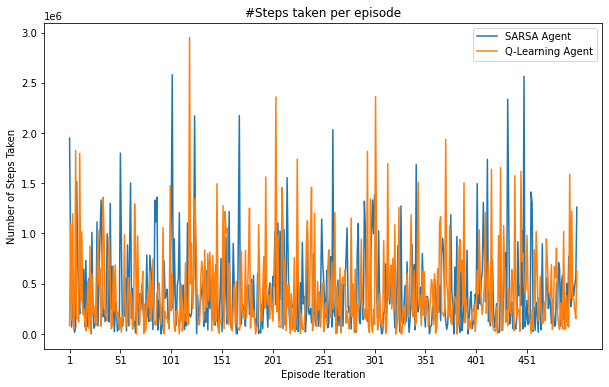

In [17]:
plt.figure(figsize = (10, 6))
plt.plot(np.arange(num_episode), num_steps_sarsa, label = "SARSA Agent")
plt.plot(np.arange(num_episode), num_steps_qlearn, label = "Q-Learning Agent")
plt.xticks(np.arange(0, num_episode, 50), np.arange(1, num_episode + 1, 50))
plt.ylabel("Number of Steps Taken")
plt.xlabel("Episode Iteration")
plt.title("#Steps taken per episode")
plt.legend()
plt.show()